In [718]:
import pandas as pd
import pandas_flavor as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import janitor
# from janitor import remove_columns, rename_column, remove_empty, filter_on, groupby_agg, clean_names

In [719]:
birth_rate_df = pd.read_csv('../data/birth_rate_cl.csv')
birth_rate_df.head(10)

,country,year,birth_rate_per_thousand
0,Afghanistan,1979,48.1
1,Afghanistan,2000,41.2
2,Afghanistan,2009,35.6
3,Albania,1970,32.5
4,Albania,1985,26.2
5,Albania,1995,23.6
6,Albania,2005,12.6
7,Albania,2011,10.1
8,Algeria,1970,43.9
9,Algeria,1985,38.3


In [720]:
birth_rate_df = birth_rate_df.groupby([birth_rate_df['country'], birth_rate_df['year'] // 10 * 10]).agg({'birth_rate_per_thousand': 'mean'}).reset_index()
birth_rate_df

,country,year,birth_rate_per_thousand
0,Afghanistan,1970,48.10
1,Afghanistan,2000,38.40
2,Albania,1970,32.50
3,Albania,1980,26.20
4,Albania,1990,23.60
...,...,...,...
943,Zambia,2000,43.45
944,Zimbabwe,1960,47.00
945,Zimbabwe,1980,39.50
946,Zimbabwe,1990,31.80


In [721]:
fertility_rate_df = pd.read_csv('../data/fertility_rates_cl.csv')
fertility_rate_df.head(10)


,country,total_fertility,mean_age_at_childbearing_,year
0,Afghanistan,8.21,30.0,1970
1,Afghanistan,7.52,30.1,2005
2,Afghanistan,5.11,29.1,2020
3,Albania,5.16,29.7,1970
4,Albania,3.33,28.8,1985
5,Albania,2.86,27.6,1995
6,Albania,1.61,27.7,2005
7,Albania,1.33,28.2,2020
8,Algeria,7.86,30.4,1970
9,Algeria,5.35,31.8,1985


In [722]:

fertility_rate_df = fertility_rate_df.groupby([fertility_rate_df['country'], fertility_rate_df['year'] // 10 * 10]).agg({'total_fertility': 'mean'}).reset_index()
fertility_rate_df

,country,year,total_fertility
0,Afghanistan,1970,8.21
1,Afghanistan,2000,7.52
2,Afghanistan,2020,5.11
3,Albania,1970,5.16
4,Albania,1980,3.33
...,...,...,...
997,Zimbabwe,1970,6.74
998,Zimbabwe,1980,5.42
999,Zimbabwe,1990,3.98
1000,Zimbabwe,2000,3.80


In [723]:
gdp_df = (
    pd.read_csv('../data/gdp_cl.csv')
    .rename(columns={'Country': 'country', 'Year': 'year'})
)
gdp_df.head(10)

,country,year,GDP_Per_Capita
0,Afghanistan,2021,372.548875
1,Afghanistan,2020,516.866543
2,Afghanistan,2019,500.522664
3,Afghanistan,2018,502.056771
4,Afghanistan,2017,530.149831
5,Afghanistan,2016,520.252064
6,Afghanistan,2015,554.403216
7,Afghanistan,2014,597.584579
8,Afghanistan,2013,622.100518
9,Afghanistan,2012,628.116539


In [724]:
gdp_df = gdp_df.groupby([gdp_df['country'], gdp_df['year'] // 10 * 10]).agg({'GDP_Per_Capita': 'mean'}).reset_index()

gdp_df.head(10)

,country,year,GDP_Per_Capita
0,Afghanistan,1970,193.997417
1,Afghanistan,1980,309.484539
2,Afghanistan,1990,200.836356
3,Afghanistan,2000,269.679250
4,Afghanistan,2010,556.981762
5,Afghanistan,2020,444.707709
6,Albania,1970,968.014660
7,Albania,1980,755.634869
8,Albania,1990,686.496243
9,Albania,2000,2555.608841


In [725]:
merged_df = gdp_df.merge(birth_rate_df, on=['year', 'country'], how='left').merge(fertility_rate_df, on=['year', 'country'], how='left')

def interpolate_by_group(group):
    return group.interpolate(method='linear').reset_index(drop=True)

drop_na_df = merged_df.dropna()
forward_fill_df = merged_df.fillna(method='ffill') 
linear_df = merged_df.apply(interpolate_by_group).reset_index(level=0, drop=True)
# polynomial = merged_df.groupby('country').interpolate(method='polynomial', order=2)

print(f'dropping null values: \n {drop_na_df.head(20).to_string(index=False)}')
# print(f'no fill: \n {merged_df.head(20).to_string(index=False)}')
# print(f'forward fill: \n{forward_fill.head(20).to_string(index=False)}')
# print(f'linear fill:\n {linear.head(20).to_string(index=False)}')
# print(f'polynomial fill order 2:\n {polynomial.head(30)}')

dropping null values: 
             country  year  GDP_Per_Capita  birth_rate_per_thousand  total_fertility
        Afghanistan  1970      193.997417                     48.1             8.21
        Afghanistan  2000      269.679250                     38.4             7.52
            Albania  1970      968.014660                     32.5             5.16
            Albania  1980      755.634869                     26.2             3.33
            Albania  1990      686.496243                     23.6             2.86
            Albania  2000     2555.608841                     12.6             1.61
            Algeria  1970      936.336972                     43.9             7.86
            Algeria  1980     2435.600459                     38.3             5.35
            Algeria  1990     1733.798177                     25.1             4.38
            Algeria  2000     2952.776905                     21.4             2.38
            Andorra  2000    37550.253517           

In [726]:
# Calculate GDP change

# Grouping by country means subsequent operations will be performed for each country individually
# GDP.apply() means we are taking the value for GDP_Per_Capita and using it for each country as x in our lambda function, 
# which takes the first and last values using integer location, since we are grouping by GDP we can use iloc[0] to grab first value and subtracting
# that from the last value iloc[-1]

gdp_change = drop_na_df.groupby('country')['GDP_Per_Capita'].apply(lambda x: x.iloc[-1] - x.iloc[0])

# Top 5 countries with greatest positive change
top_positive = gdp_change.nlargest(5).index.tolist()

# Top 5 countries with greatest negative change
top_negative = gdp_change.nsmallest(5).index.tolist()

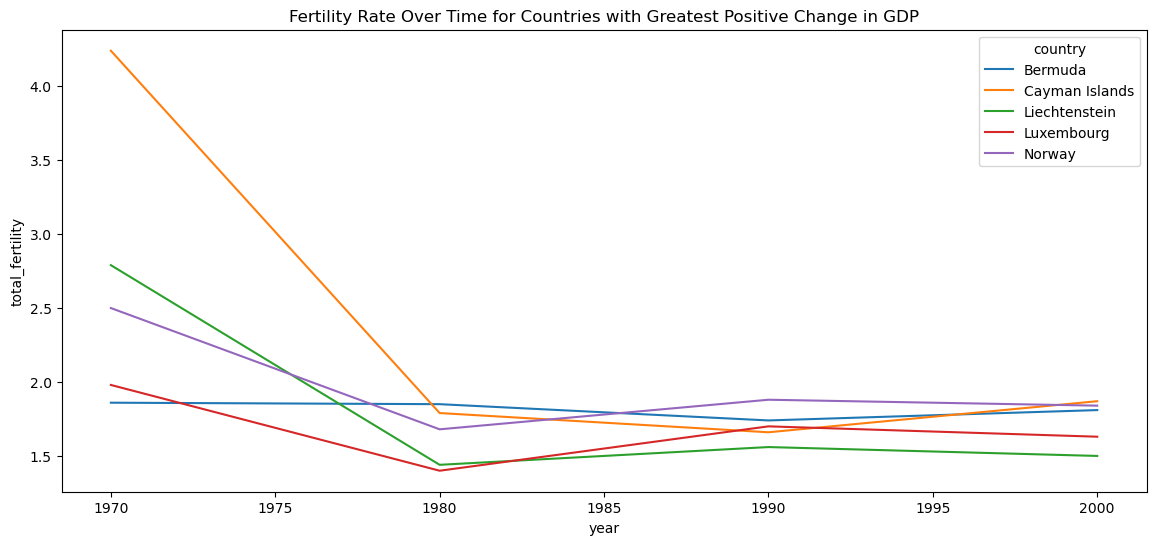

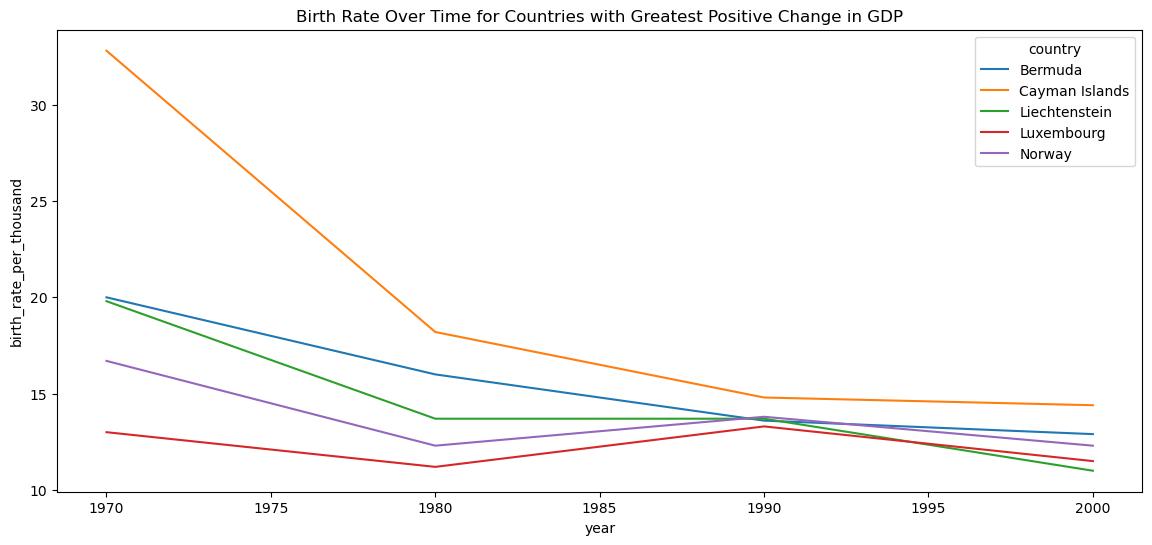

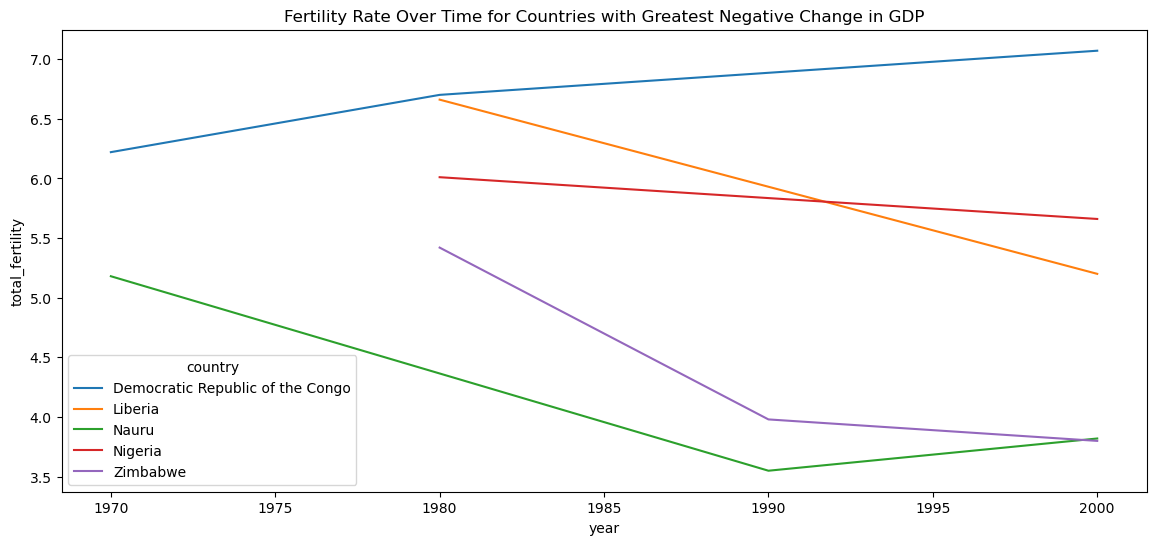

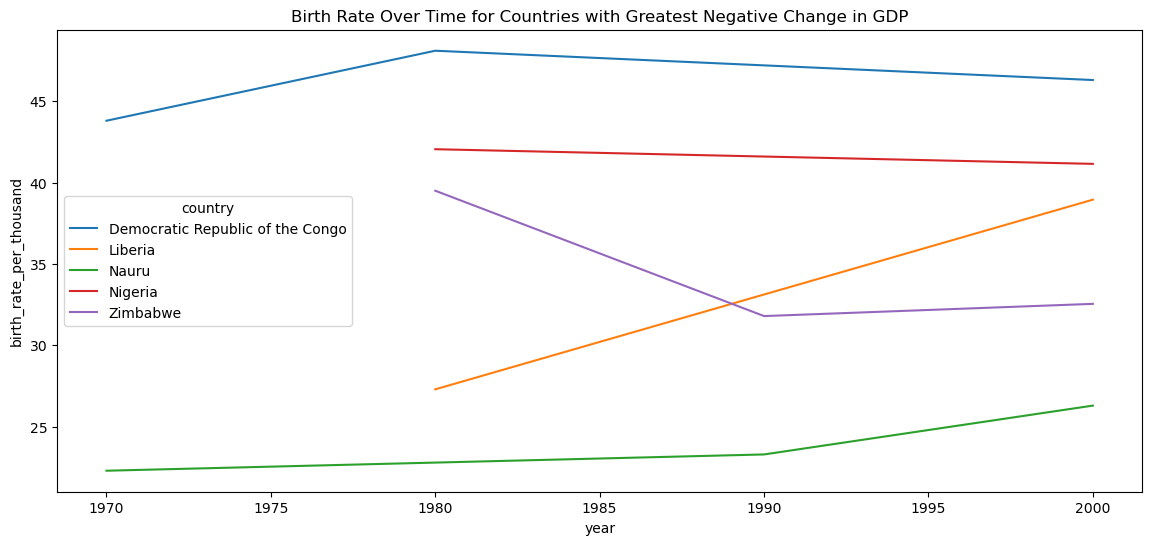

In [727]:
# Filter the DataFrame for top countries
positive_df = drop_na_df[drop_na_df['country'].isin(top_positive)]
negative_df = drop_na_df[drop_na_df['country'].isin(top_negative)]

# Plotting fertility rate for countries with greatest positive GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=positive_df, x='year', y='total_fertility', hue='country')
plt.title("Fertility Rate Over Time for Countries with Greatest Positive Change in GDP")
plt.show()

# Plotting birth rate for countries with greatest positive GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=positive_df, x='year', y='birth_rate_per_thousand', hue='country')
plt.title("Birth Rate Over Time for Countries with Greatest Positive Change in GDP")
plt.show()

# Plotting fertility rate for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=negative_df, x='year', y='total_fertility', hue='country')
plt.title("Fertility Rate Over Time for Countries with Greatest Negative Change in GDP")
plt.show()

# Plotting birth rate for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=negative_df, x='year', y='birth_rate_per_thousand', hue='country')
plt.title("Birth Rate Over Time for Countries with Greatest Negative Change in GDP")
plt.show()
